<a href="https://colab.research.google.com/github/frederik-kilpinen/ASDS2/blob/main/topic_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing erlevant packages 
import numpy as np
import pandas as pd
from datetime import datetime 
from tqdm import tqdm 
import logging 
import sys 
import pickle 
import requests
import io

#Importing NLTK and NLP packages
import nltk
from nltk.tokenize import TweetTokenizer
import string
import re
from collections import defaultdict

#Importing packages for data visualization 
import matplotlib.pyplot as plt
import seaborn as sns

#Importing packages for LDA
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore

In [2]:
#Importing and viewing data
tweets = pd.read_csv("/content/drive/MyDrive/Digital methods/mp_tweets")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Dropping useless column
tweets = tweets.drop("Unnamed: 0", axis=1)

In [4]:
#Reusing and tweaking the function for preprocessing from last week to fit specifics of this dataset.
def preprocess(text):
    
    #Lowercasing words
    text = str(text)
    text = text.lower()
    
    #Removing '&amp' which was found to be common
    text = re.sub(r'&amp','', text)
    
    #Replace other instances of "&" with "and"
    text = re.sub(r'&','and', text)
    
    #Removing mentions 
    text = re.sub(r'@\w+ ', '', text)
    
    #Removing 'RT' and 'via'
    text = re.sub(r'(^rt|^via)((?:\b\W*@\w+)+): ', '', text)
    
    #Removing punctuation
    my_punctuation = string.punctuation.replace('#','')
    my_punctuation = my_punctuation.replace('-','')
    
    text = text.translate(str.maketrans('', '', my_punctuation))
    text = re.sub(r' - ','', text) #removing dash lines bounded by whitespace (and therefore not part of a word)
    text = re.sub(r'[’“”—,!]','',text) #removing punctuation that is not captured by string.punctuation
    
    #Removing odd special characters
    text = re.sub(r"[┻┃━┳┓┏┛┗]","", text)
    text = re.sub(r"\u202F|\u2069|\u200d|\u2066","", text)
    
    #Removing URLs
    text = re.sub(r'http\S+', '', text)
    
    #Removing numbers
    text = re.sub(r'[0-9]','', text)
    
    #Removing separators and superfluous whitespace
    text = text.strip()
    text = re.sub(r' +',' ',text)
    
    #Tokenizing
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    
    return tokens
    

def preprocess_lemma(tokens):
    
    #Running the preprocess function
    tokens = preprocess(tokens)
    
    #Lemmatizing
    tag_map = defaultdict(lambda : nltk.corpus.wordnet.NOUN)      #POS map
    tag_map['J'] = nltk.corpus.wordnet.ADJ
    tag_map['V'] = nltk.corpus.wordnet.VERB
    tag_map['R'] = nltk.corpus.wordnet.ADV    
    
    lemmatizer = nltk.WordNetLemmatizer()             #Creating lemmatizer.
    text_lemmatized = []                              #Empty list to save lemmatized sentence

    for word, tag in nltk.pos_tag(tokens):
        lemma = lemmatizer.lemmatize(word, tag_map[tag[0]])
        text_lemmatized.append(lemma)
    
    tokens = text_lemmatized

    #Removing stopwords
    stop_words_list = nltk.corpus.stopwords.words("english")
    text = " ".join([i for i in tokens if i not in stop_words_list])
    
    return text

def preprocess_stem(tokens):
    
    #Running the preprocess function
    tokens = preprocess(tokens)
    
    #Removing stopwords
    stop_words_list = nltk.corpus.stopwords.words("english")
    tokens = [i for i in tokens if i not in stop_words_list]
    
    #Stemming
    stemmer = nltk.PorterStemmer()    #Creating stemmer
    sent_stemmed = []                 #Empty list to save stemmed sentence
    
    for word in tokens:
        stem = stemmer.stem(word)     #Stemming words
        sent_stemmed.append(stem)
        
    tokens = sent_stemmed
    
    return " ".join(tokens)

In [5]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
# Lemmatizing tweets
tweets["text_lemmatized"] = tweets.full_text.apply(lambda x: preprocess_lemma(x))

# Stemming tweets
tweets["text_stemmed"] = tweets.full_text.apply(lambda x: preprocess_stem(x))

In [7]:
#Replacing nan values with empty strings
tweets.text_lemmatized = tweets.text_lemmatized.apply(lambda x: '' if str(x) == 'nan' else x)
tweets.text_stemmed = tweets.text_stemmed.apply(lambda x: '' if str(x) == 'nan' else x)

In [10]:
# Getting mp party affiliation from relevant dataset
url = "https://raw.githubusercontent.com/frederik-kilpinen/ASDS2/main/Notebooks/data/australian_mps.csv?token=AKJV3DEMBOPHGVEAWN3HLDDAUERSO"
download = requests.get(url).content
f = pd.read_csv(io.StringIO(download.decode('utf-8')))
mp_party = f.drop(["Unnamed: 0",	"p.country",	"m.name", "twitter_handle"], axis=1)

In [11]:
# Merging party affiliation unto tweets
tweets = tweets.merge(mp_party, left_on='user_id', right_on='m.uid').drop("m.uid", axis=1)

In [12]:
# Reducing created_at column to days
tweets["date"] = pd.to_datetime(tweets["created_at"]).dt.date

In [13]:
#Aggregating tweet data by dates and party 
tweets_agg = tweets.groupby(['date', 'p.party'], as_index = False).agg({'full_text': ' '.join,
                                                                            'text_lemmatized': ' '.join,
                                                                            'text_stemmed': ' '.join})

In [14]:
#Defining NLTK's TweetTokenizer
tokenizer = TweetTokenizer()

tqdm.pandas()

#Creating a column of unigrams from the stemmed tweet text
tweets_agg['unigrams'] = tweets_agg['text_stemmed'].progress_apply(lambda x: tokenizer.tokenize(x))

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 18045/18045 [00:19<00:00, 936.96it/s]


In [ ]:
# NOT WORKING: BIGRAMS

#Defining a function that will create bigrams 
#def bigrams(doc):
    
#    bigrams = [] #Empty list to save the bigrams
    
#    for bigram in list(nltk.bigrams(doc)):  #Creating bigrams and iterating over them
#        bigrams.append("_".join(bigram))    #Connecting each bigram pair with an underscore and saving to list
    
#    return bigrams

#Creating a column with bigrams
#tweets_agg['bigrams'] = tweets_agg.unigrams.progress_apply(lambda x: bigrams(x))

#Combining unigrams and bigrams in one column
#tweets_agg['tokens'] = tweets_agg.unigrams+tweets_agg.bigrams

In [15]:
#Create a id2word dictionary
tweets_agg['tokens'] = tweets_agg['unigrams'] # Should be removed if we can get bigrams

#Insert the column where you saved unigram and bigram tokens between the parentheses
id2word = Dictionary(tweets_agg['tokens']) 

#Removing very frequent and infrequent words
id2word.filter_extremes(no_below=10, no_above=.999, keep_n = None)

#Creating a corpus object 
corpus = [id2word.doc2bow(doc) for doc in tweets_agg['tokens']]


# **Topic modelling**

In [16]:
#Instantiating a logger to get information on the progress of the LDA
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#Running the LDA with 20 topics 
lda_model = LdaMulticore(corpus=corpus, num_topics=20, id2word=id2word, passes = 10, iterations = 100) # should be changed to passes = 100, iterations = 1000

#Disabling logging
logging.disable(sys.maxsize)

2021-05-16 13:50:31,863 : INFO : using symmetric alpha at 0.05
2021-05-16 13:50:31,865 : INFO : using symmetric eta at 0.05
2021-05-16 13:50:31,874 : INFO : using serial LDA version on this node
2021-05-16 13:50:31,914 : INFO : running online LDA training, 20 topics, 10 passes over the supplied corpus of 18045 documents, updating every 2000 documents, evaluating every ~18045 documents, iterating 100x with a convergence threshold of 0.001000
2021-05-16 13:50:31,919 : INFO : training LDA model using 1 processes
2021-05-16 13:50:31,957 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/18045, outstanding queue size 1
2021-05-16 13:50:32,031 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/18045, outstanding queue size 2
2021-05-16 13:50:32,110 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/18045, outstanding queue size 3
2021-05-16 13:50:36,800 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/18045, ou

In [22]:
#Finding the 10 most predictive tokens for each topic

#Using regex to filter the words from the weights 
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics(15,10)]

# Printing the topics in a nice format
for id, t in enumerate(words): 
    print(f"------ Topic {id} ------")
    print(' '.join(t), end="\n\n")

------ Topic 0 ------
region commun water project rural govern #regionsmatt million invest feder

------ Topic 1 ------
… day leav liber #auspol year union today govern elect

------ Topic 2 ------
… 👇 australian govern need peopl morrison australia commun covid

------ Topic 3 ------
… quarantin morrison australian vaccin govern citizen get #auspol time

------ Topic 4 ------
… today new great busi announc support #auspol minist local

------ Topic 5 ------
… govern morrison australian #auspol budget liber plan invest job

------ Topic 6 ------
australia 🇺 australian 🇦 … - econom first work great

------ Topic 7 ------
servic today day #tyfi anzac veteran women support local work

------ Topic 8 ------
#tyfi australia support australian aussi work … famili servic great

------ Topic 9 ------
great thank today student school australia commun morn good …

------ Topic 10 ------
… morrison job scott australian today good time thank day

------ Topic 11 ------
labor … #auspol turnbul cut 

In [23]:
#Creating a dataframe with tokens as columns and topics as rows 
beta_df = pd.DataFrame(lda_model.get_topics(), columns = list(id2word.token2id.keys()))

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127462 missing from current font.
  font.set_text(s, 0, flags=flags)


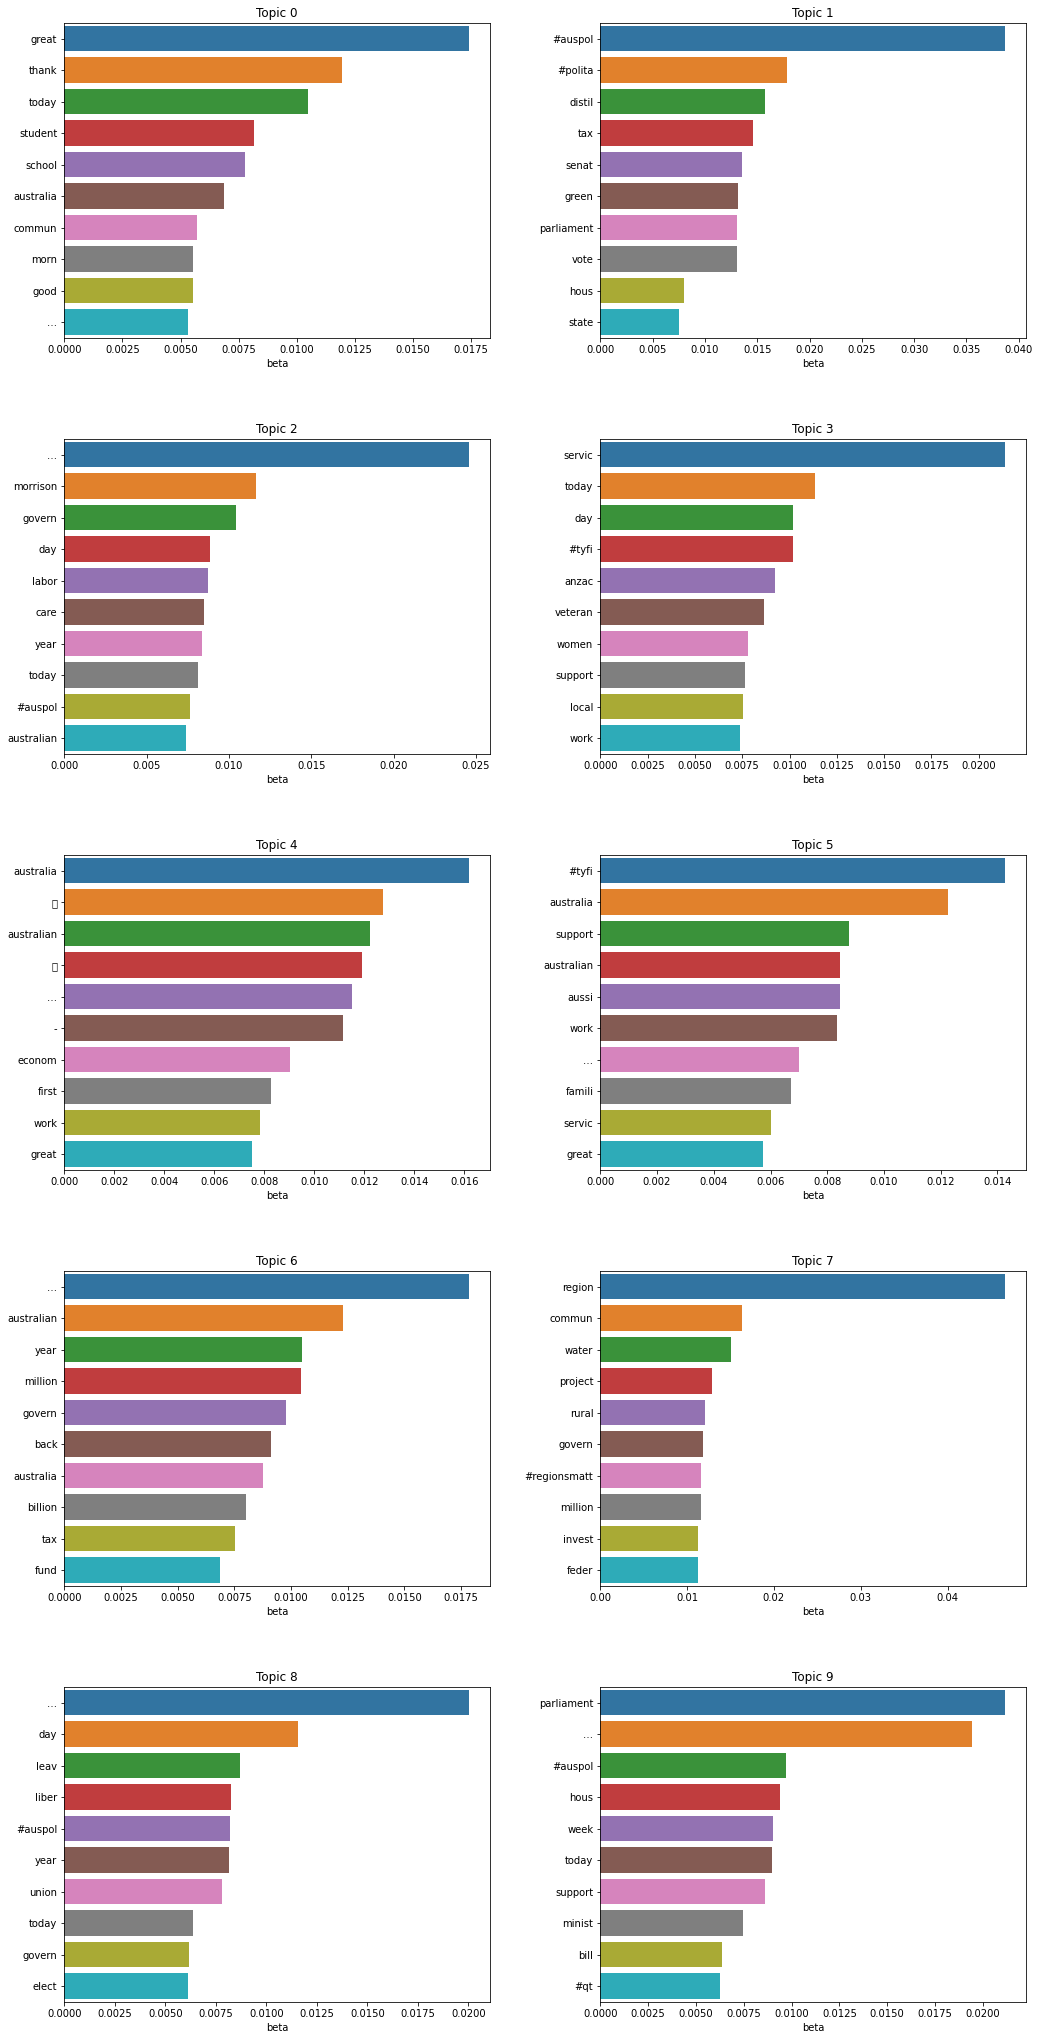

In [24]:
#Picking 10 topics to visualize
topics = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13 ,14]

fig, axes = plt.subplots(ncols=2, nrows=5, figsize = (16,30)) #Setting 10 subplots and determining figure size
fig.tight_layout(pad=8.0) #This ensure space between the subplots so the text can more easily be read
    
for ax, topic in zip(axes.flatten(), topics): #Iterates through the axes and the topics
    
    #Creates 10 barplots with x as the beta values and y as the words
    sns.barplot(ax = ax, 
                x = beta_df.iloc[topic].nlargest(10).values, 
                y = beta_df.iloc[topic].nlargest(10).index, 
                orient = 'h')
    
    ax.set(title='Topic {}'.format(topic), xlabel='beta')

plt.show()

In [26]:
#Insert the corpus of documents in bag of word format and get a list of (topic, probability) per document. 
document_topics = list(lda_model.get_document_topics(corpus)) 

#Creating a list of names for all 15 topics
topics = ['topic_{}'.format(t) for t in range(0,15)]

#Creating a dataframe of gamma probabilities 
gamma_probs = pd.DataFrame(np.zeros((len(document_topics),15)), columns = topics)

for i, doc in enumerate(document_topics): 
    for pair in doc: 
        gamma_probs.loc[i,'topic_{}'.format(pair[0])] = pair[1]

In [27]:
#Merging with the original dataframe 
gamma_df = pd.concat((tweets_agg,gamma_probs), axis = 1)

In [28]:
#Using regex to find all words and filter them from the weights
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics(15,10)]

# Printing the topics in a nice format
for id, t in enumerate(words): 
    print(f"------ Topic {id} ------")
    print(' '.join(t), end="\n\n")

------ Topic 0 ------
#auspol #polita distil tax senat green parliament vote hous state

------ Topic 1 ------
great thank today student school australia commun morn good …

------ Topic 2 ------
great day year today commun new congratul thank local celebr

------ Topic 3 ------
#tyfi australia support australian aussi work … famili servic great

------ Topic 4 ------
australia 🇺 australian 🇦 … - econom first work great

------ Topic 5 ------
… day leav liber #auspol year union today govern elect

------ Topic 6 ------
… australian year million govern back australia billion tax fund

------ Topic 7 ------
region commun water project rural govern #regionsmatt million invest feder

------ Topic 8 ------
… morrison govern day labor care year today #auspol australian

------ Topic 9 ------
get want aussi ga industri support … help global coal

------ Topic 10 ------
servic today day #tyfi anzac veteran women support local work

------ Topic 11 ------
… quarantin morrison australian vaccin 

In [32]:
# Date object
gamma_df["date"] = pd.to_datetime(gamma_df["date"])

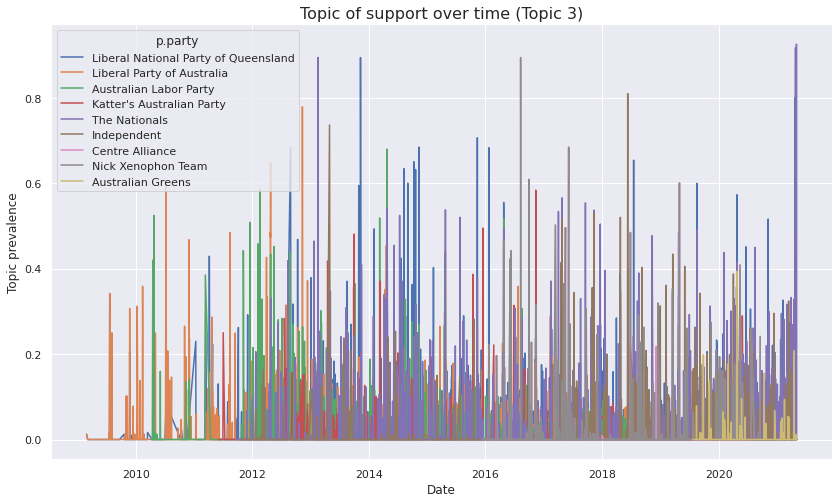

In [34]:
#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors

#Plotting the covid topic for the full dataset
sns.lineplot(x = 'date', y = 'topic_3', hue = 'p.party', data = gamma_df)

plt.title('Topic of support over time (Topic 3)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

plt.show()